### **- Using insider trading data to determine whether the stock price will rise or not.**

#### Here I am using insider trading data, to predict whether the stock price moved significantly in the following 30 days from when the above transaction reports released.

#### For better results I am using only Hold and Buy as values for the target column, since I am taking the maximum **close** value of the stock price for the following 30 days of each transaction.

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import missingno as msno
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.impute import KNNImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder

2024-09-18 22:48:24.641583: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-18 22:48:24.644566: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-18 22:48:24.753979: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-18 22:48:24.801407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 22:48:24.888202: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
stock_symbol = 'SHOP'
insider_df = pd.read_csv('InsiderTranDATA/' + stock_symbol + '.csv')
insider_df = insider_df.drop('isDerivative', axis=1)
# analyst_est_df['dym'] = analyst_est_df['date'].dt.to_period('M')
insider_df['filingDate'] = pd.to_datetime(insider_df['filingDate'])
insider_df

,change,currency,filingDate,id,name,share,source,symbol,transactionCode,transactionDate,transactionPrice
0,229,CAD,2024-04-01,NaN,"Nejatian, Kasra",189281,sedi,SHOP,57,2024-04-01,0.0000
1,-229,CAD,2024-04-01,NaN,"Nejatian, Kasra",608372,sedi,SHOP,57,2024-04-01,0.0000
2,-23,CAD,2024-04-01,NaN,"Finkelstein, Harley Michael",36802,sedi,SHOP,10,2024-04-01,78.1444
3,42,CAD,2024-04-01,NaN,"Finkelstein, Harley Michael",36825,sedi,SHOP,57,2024-04-01,0.0000
4,-42,CAD,2024-04-01,NaN,"Finkelstein, Harley Michael",189454,sedi,SHOP,57,2024-04-01,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
171,274,CAD,2023-08-01,NaN,"Nejatian, Kasra",116388,sedi,SHOP,57,2023-07-31,0.0000
172,-274,CAD,2023-08-01,NaN,"Nejatian, Kasra",173879,sedi,SHOP,57,2023-07-31,0.0000
173,-28,CAD,2023-08-01,NaN,"Finkelstein, Harley Michael",105278,sedi,SHOP,10,2023-07-31,67.2482
174,51,CAD,2023-08-01,NaN,"Finkelstein, Harley Michael",105306,sedi,SHOP,57,2023-07-31,0.0000


In [3]:
insider_min_date = insider_df['filingDate'].min()
today = datetime.date.today()
stock_prices_df = yf.download(stock_symbol, insider_min_date, today)

[*********************100%%**********************]  1 of 1 completed


In [4]:
stock_prices_df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Close'], inplace=True)
stock_prices_df

,Adj Close
Date,
2023-08-01,67.449997
2023-08-02,62.430000
2023-08-03,59.040001
2023-08-04,57.930000
2023-08-07,57.570000
...,...
2024-09-11,71.519997
2024-09-12,71.309998
2024-09-13,72.449997


In [5]:
monthly_max_df = stock_prices_df['Adj Close'].to_frame()
monthly_max_df = monthly_max_df.reset_index();
monthly_max_df

,Date,Adj Close
0,2023-08-01,67.449997
1,2023-08-02,62.430000
2,2023-08-03,59.040001
3,2023-08-04,57.930000
4,2023-08-07,57.570000
...,...,...
280,2024-09-11,71.519997
281,2024-09-12,71.309998
282,2024-09-13,72.449997
283,2024-09-16,73.580002


#### Filter out the transactions that were more of a documentation. They don't trade shares, and transactionPrice is 0.000 for these type of transactions, so we don't need them.

In [6]:
insider_df = insider_df[insider_df['transactionPrice'] != 0.000]
insider_df = insider_df.reset_index(drop=True)
insider_df

,change,currency,filingDate,id,name,share,source,symbol,transactionCode,transactionDate,transactionPrice
0,-23,CAD,2024-04-01,NaN,"Finkelstein, Harley Michael",36802,sedi,SHOP,10,2024-04-01,78.1444
1,-1881,CAD,2024-04-01,NaN,"Hoffmeister, Jeff",32305,sedi,SHOP,10,2024-03-28,78.8315
2,-764,CAD,2024-04-01,NaN,"Hertz, Jessica",11539,sedi,SHOP,10,2024-03-28,78.8315
3,-426,CAD,2024-04-01,NaN,"Finkelstein, Harley Michael",36783,sedi,SHOP,10,2024-03-28,78.8315
4,-23,CAD,2024-02-01,NaN,"Finkelstein, Harley Michael",91135,sedi,SHOP,10,2024-01-31,80.8115
...,...,...,...,...,...,...,...,...,...,...,...
79,-240,CAD,2023-09-01,NaN,"Finkelstein, Harley Michael",107481,sedi,SHOP,30,2023-08-30,58.5900
80,-240,CAD,2023-09-01,NaN,"Finkelstein, Harley Michael",107721,sedi,SHOP,30,2023-08-30,58.5900
81,-2435,CAD,2023-08-28,NaN,"Hertz, Jessica",18314,sedi,SHOP,10,2023-08-24,56.5121
82,-3308,CAD,2023-08-28,NaN,"Finkelstein, Harley Michael",107961,sedi,SHOP,10,2023-08-24,56.5121


In [7]:
merged_df = pd.merge(insider_df, monthly_max_df, how='right', left_on='filingDate', right_on='Date')
merged_df = merged_df.sort_values('Date', ascending=False)
merged_df

,change,currency,filingDate,id,name,share,source,symbol,transactionCode,transactionDate,transactionPrice,Date,Adj Close
319,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-17,74.449997
318,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-16,73.580002
317,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-13,72.449997
316,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-12,71.309998
315,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-11,71.519997
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-07,57.570000
3,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-04,57.930000
2,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-03,59.040001
1,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-02,62.430000


#### We find the maximum price for each trading day in the next 30 days, and then we drop the ones that have NaNs in transactionPrice, because those are from the yfinance price dataframe and we don't need them.

In [8]:
merged_df['max_price_after_tran'] = (
    merged_df['Adj Close'] 
    .shift(-1) 
    .rolling(window=30, min_periods=1) 
    .max()
)
merged_df

,change,currency,filingDate,id,name,share,source,symbol,transactionCode,transactionDate,transactionPrice,Date,Adj Close,max_price_after_tran
319,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-17,74.449997,73.580002
318,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-16,73.580002,73.580002
317,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-13,72.449997,73.580002
316,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-12,71.309998,73.580002
315,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-11,71.519997,73.580002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-07,57.570000,66.709999
3,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-04,57.930000,66.709999
2,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-03,59.040001,66.709999
1,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-08-02,62.430000,67.449997


In [9]:
merged_df = merged_df.dropna(subset=['transactionPrice'])
merged_df = merged_df.reset_index(drop=True)
merged_df

,change,currency,filingDate,id,name,share,source,symbol,transactionCode,transactionDate,transactionPrice,Date,Adj Close,max_price_after_tran
0,-23.0,CAD,2024-04-01,NaN,"Finkelstein, Harley Michael",36802.0,sedi,SHOP,10.0,2024-04-01,78.1444,2024-04-01,78.190002,78.190002
1,-1881.0,CAD,2024-04-01,NaN,"Hoffmeister, Jeff",32305.0,sedi,SHOP,10.0,2024-03-28,78.8315,2024-04-01,78.190002,78.190002
2,-764.0,CAD,2024-04-01,NaN,"Hertz, Jessica",11539.0,sedi,SHOP,10.0,2024-03-28,78.8315,2024-04-01,78.190002,78.190002
3,-426.0,CAD,2024-04-01,NaN,"Finkelstein, Harley Michael",36783.0,sedi,SHOP,10.0,2024-03-28,78.8315,2024-04-01,78.190002,78.190002
4,-23.0,CAD,2024-02-01,NaN,"Finkelstein, Harley Michael",91135.0,sedi,SHOP,10.0,2024-01-31,80.8115,2024-02-01,76.720001,90.720001
5,-1875.0,CAD,2024-01-17,NaN,"Nejatian, Kasra",169016.0,sedi,SHOP,30.0,2024-01-16,80.2000,2024-01-17,80.320000,90.720001
6,-27.0,CAD,2024-01-03,NaN,"Finkelstein, Harley Michael",91116.0,sedi,SHOP,10.0,2024-01-02,74.2960,2024-01-03,71.820000,90.720001
7,-12000.0,CAD,2024-01-03,NaN,"Hertz, Jessica",3239.0,sedi,SHOP,30.0,2024-01-02,73.9250,2024-01-03,71.820000,90.720001
8,-3100.0,CAD,2023-12-20,NaN,"Finkelstein, Harley Michael",94196.0,sedi,SHOP,30.0,2023-12-19,78.0000,2023-12-20,75.419998,83.540001
9,-3100.0,CAD,2023-12-20,NaN,"Finkelstein, Harley Michael",91096.0,sedi,SHOP,30.0,2023-12-19,79.0132,2023-12-20,75.419998,83.540001


#### - In the following cell I am creating the target column **trend**. We have percentage_limit that defines what should our criteria be for determening whether the stock price has risen significantly or not. I tried different options for this value, and it seems it depends what kind of stock we have, and how much data we have. It works differently for different kind of scenarios. I would maybe improve this part by cross validating this value and see for what value perhaps from 0 to 10 the models give the best result. Or maybe this can be like a user input.
#### - Calculating the percentage change from the **transactionPrice** for which the insider sold the shares and the max price in the following 30 days. Then creating an interval that defines our Hold or Buy target column using the pct_chage column.

In [10]:
percentage_limit = 5
merged_df['pct_change'] = (merged_df['max_price_after_tran'] - merged_df['transactionPrice'] ) / merged_df['max_price_after_tran'] * 100

conditions = [
    (merged_df['pct_change'] >= percentage_limit),   
    (merged_df['pct_change'] < -percentage_limit) 
    # (merged_df['pct_change'].between(-percentage_limit, percentage_limit)) 
]

# choices = ['Buy', 'Hold', 'Hold']
choices = ['Buy', 'Hold']

merged_df['trend'] = pd.cut(merged_df['pct_change'], bins=[-float('inf'), percentage_limit,
                                                           float('inf')], labels=['Hold', 'Buy'])
# merged_df['trend'] = pd.cut(merged_df['pct_change'], bins=[-float('inf'), -percentage_limit, percentage
                                                           # float('inf')], labels=['Sell', 'Hold', 'Buy'])


In [11]:
ready_df = merged_df.drop(columns=['Date', 'id', 'symbol', 'pct_change', 'Adj Close', 'max_price_after_tran', 'currency', 'filingDate', 'transactionDate', 'source'], inplace=False)

In [12]:
ready_df

,change,name,share,transactionCode,transactionPrice,trend
0,-23.0,"Finkelstein, Harley Michael",36802.0,10.0,78.1444,Hold
1,-1881.0,"Hoffmeister, Jeff",32305.0,10.0,78.8315,Hold
2,-764.0,"Hertz, Jessica",11539.0,10.0,78.8315,Hold
3,-426.0,"Finkelstein, Harley Michael",36783.0,10.0,78.8315,Hold
4,-23.0,"Finkelstein, Harley Michael",91135.0,10.0,80.8115,Buy
5,-1875.0,"Nejatian, Kasra",169016.0,30.0,80.2000,Buy
6,-27.0,"Finkelstein, Harley Michael",91116.0,10.0,74.2960,Buy
7,-12000.0,"Hertz, Jessica",3239.0,30.0,73.9250,Buy
8,-3100.0,"Finkelstein, Harley Michael",94196.0,30.0,78.0000,Buy
9,-3100.0,"Finkelstein, Harley Michael",91096.0,30.0,79.0132,Buy


In [13]:
ready_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   change            54 non-null     float64 
 1   name              54 non-null     object  
 2   share             54 non-null     float64 
 3   transactionCode   54 non-null     float64 
 4   transactionPrice  54 non-null     float64 
 5   trend             54 non-null     category
dtypes: category(1), float64(4), object(1)
memory usage: 2.4+ KB


<Axes: >

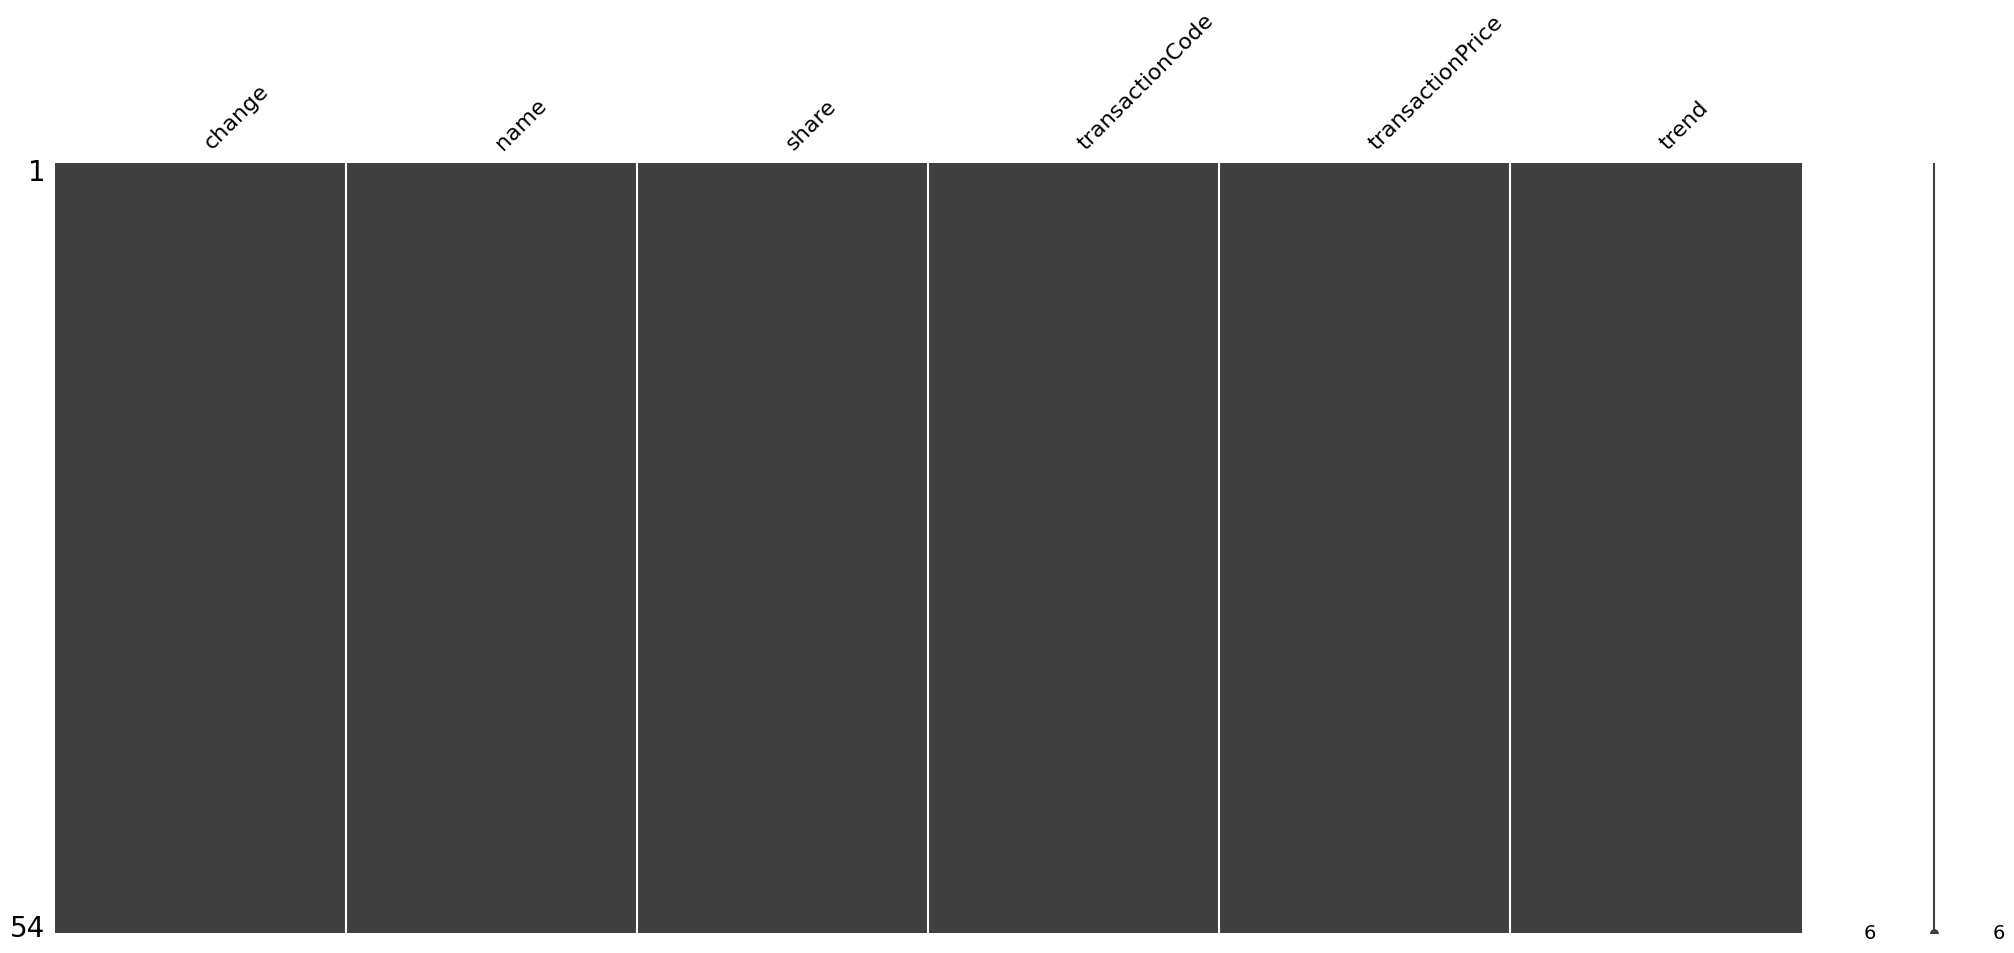

In [14]:
msno.matrix(ready_df)

In [15]:
name_encoder = LabelEncoder()
trend_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse_output=False)

encoded_names = onehot_encoder.fit_transform(ready_df[['transactionCode']])
encoded_names_df = pd.DataFrame(encoded_names, columns=onehot_encoder.get_feature_names_out(['transactionCode']))
ready_df = pd.concat([ready_df, encoded_names_df], axis=1)
ready_df.drop(columns=['transactionCode'], inplace=True)

ready_df['trend'] = trend_encoder.fit_transform(ready_df['trend'])
ready_df['name'] = name_encoder.fit_transform(ready_df['name'])
ready_df

,change,name,share,transactionPrice,trend,transactionCode_10.0,transactionCode_30.0,transactionCode_50.0
0,-23.0,0,36802.0,78.1444,1,1.0,0.0,0.0
1,-1881.0,2,32305.0,78.8315,1,1.0,0.0,0.0
2,-764.0,1,11539.0,78.8315,1,1.0,0.0,0.0
3,-426.0,0,36783.0,78.8315,1,1.0,0.0,0.0
4,-23.0,0,91135.0,80.8115,0,1.0,0.0,0.0
5,-1875.0,3,169016.0,80.2000,0,0.0,1.0,0.0
6,-27.0,0,91116.0,74.2960,0,1.0,0.0,0.0
7,-12000.0,1,3239.0,73.9250,0,0.0,1.0,0.0
8,-3100.0,0,94196.0,78.0000,0,0.0,1.0,0.0
9,-3100.0,0,91096.0,79.0132,0,0.0,1.0,0.0


#### Not including the last transaction row, since we would use this on the day these insider transactions come out, and we won't have future prices for the last row, maybe for the couple of last rows even(this will need to be handled).

In [16]:
last_row = ready_df.head(1).drop(columns=['trend'])

In [17]:
last_row

,change,name,share,transactionPrice,transactionCode_10.0,transactionCode_30.0,transactionCode_50.0
0,-23.0,0,36802.0,78.1444,1.0,0.0,0.0


In [18]:
ready_df = ready_df.iloc[1:]
ready_df.isnull().sum()

change                  0
name                    0
share                   0
transactionPrice        0
trend                   0
transactionCode_10.0    0
transactionCode_30.0    0
transactionCode_50.0    0
dtype: int64

In [19]:
X = ready_df.drop(columns='trend', inplace=False)
y = ready_df['trend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
y_train.value_counts()[1]

7

In [21]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', enable_categorical=True)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.00      0.00      0.00         2

    accuracy                           0.73        11
   macro avg       0.40      0.44      0.42        11
weighted avg       0.65      0.73      0.69        11

Accuracy: 0.7272727272727273


In [23]:
predicted_trend_encoded = model.predict(last_row)
predicted_trend = trend_encoder.inverse_transform(predicted_trend_encoded)

print("Predicted Trend:", predicted_trend[0])

Predicted Trend: Buy


In [24]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
    # Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5236 - loss: 0.6843 - val_accuracy: 0.8889 - val_loss: 0.6540
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7985 - loss: 0.6439 - val_accuracy: 1.0000 - val_loss: 0.6009
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7652 - loss: 0.6139 - val_accuracy: 1.0000 - val_loss: 0.5510
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7785 - loss: 0.5872 - val_accuracy: 1.0000 - val_loss: 0.5046
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8352 - loss: 0.5444 - val_accuracy: 1.0000 - val_loss: 0.4601
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8452 - loss: 0.5083 - val_accuracy: 1.0000 - val_loss: 0.4214
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7585 - loss: 0.5356 - val_accuracy: 1.0000 - val_loss: 0.3895
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7952 - loss: 0.5003 - val_accuracy: 1.0000 - val_loss: 0.3579
Epoch 9

In [25]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print(classification_report(y_test, y_pred, target_names=['Buy', 'Hold']))
# print(classification_report(y_test, y_pred, target_names=['Buy', 'Hold', 'Sell']))
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
              precision    recall  f1-score   support

         Buy       0.78      0.78      0.78         9
        Hold       0.00      0.00      0.00         2

    accuracy                           0.64        11
   macro avg       0.39      0.39      0.39        11
weighted avg       0.64      0.64      0.64        11

[[7 2]
 [2 0]]
Accuracy: 0.6363636363636364


In [26]:
predicted_trend_encoded = model.predict(last_row)
last_row_pred = np.argmax(predicted_trend_encoded, axis=1)
predicted_trend = trend_encoder.inverse_transform(last_row_pred)

print("Predicted Trend:", predicted_trend)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Trend: ['Buy']


In [27]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# smote = SMOTE()
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier(n_estimators=100, max_depth=43, random_state=42)
# model.fit(X_train_resampled, y_train_resampled)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# print(classification_report(y_test, y_pred, target_names=['Buy', 'Hold', 'Hold']))
print(classification_report(y_test, y_pred, target_names=['Hold', 'Buy']))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

        Hold       0.82      1.00      0.90         9
         Buy       0.00      0.00      0.00         2

    accuracy                           0.82        11
   macro avg       0.41      0.50      0.45        11
weighted avg       0.67      0.82      0.74        11

Accuracy: 0.8181818181818182


/home/meto/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/meto/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/meto/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
predicted_trend_encoded = model.predict(last_row)
predicted_trend = trend_encoder.inverse_transform(predicted_trend_encoded)

print("Predicted Trend:", predicted_trend)

Predicted Trend: ['Buy']


/home/meto/.local/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
